### LSTM

In [4]:
#import
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### setup device

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Making data ready

In [6]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()

# data_norm.head(10)

             timestamp     open     high      low    close
0  2020-01-01 17:01:00  1.12106  1.12135  1.12106  1.12106
1  2020-01-01 17:02:00  1.12136  1.12139  1.12136  1.12136
2  2020-01-01 17:03:00  1.12135  1.12135  1.12120  1.12120
3  2020-01-01 17:04:00  1.12122  1.12125  1.12122  1.12122
4  2020-01-01 17:05:00  1.12125  1.12127  1.12125  1.12125
5  2020-01-01 17:06:00  1.12127  1.12127  1.12127  1.12127
6  2020-01-01 17:07:00  1.12127  1.12127  1.12127  1.12127
7  2020-01-01 17:08:00  1.12127  1.12127  1.12127  1.12127
8  2020-01-01 17:09:00  1.12127  1.12127  1.12127  1.12127
9  2020-01-01 17:10:00  1.12127  1.12127  1.12123  1.12123
                open           high            low          close
count  372334.000000  372334.000000  372334.000000  372334.000000
mean        1.141451       1.141539       1.141364       1.141364
std         0.044322       0.044318       0.044326       0.044326
min         1.063810       1.064010       1.063570       1.063570
25%         1.100260 

### move data to tensor gpu

In [8]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor

tensor([[[1.1211],
         [1.1214],
         [1.1212],
         ...,
         [1.2216],
         [1.2215],
         [1.2214]]], device='cuda:0')

### LSTM in every 100 bars

In [9]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

### Train Modals

In [ ]:
# Parameters
input_size = 1  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 5  # Number of LSTM layers
output_size = 1  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
forecast_interval = 100
losses = []
for epoch in tqdm(range(num_epochs)):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    # Probabilistic forecasting every forecast_interval timestamps
    if (epoch+1) % forecast_interval == 0:
        with torch.no_grad():
            # Generate probabilistic forecasts for the next timestamp
            # You can adjust this part to implement your desired forecasting method
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

            # # Visualize the loss over epochs
            # plt.plot(losses)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.title('Training Loss over Epochs')
            # plt.show()

            forecast_input = data_tensor[:, -1:, :]  # Use the last timestamp as input
            forecast_output = model(forecast_input)
            print(forecast_input)
            print(forecast_output)
            
            # Append the forecasted values to the data tensor
            data_tensor = torch.cat([data_tensor, forecast_output.unsqueeze(1)], dim=1)

In [26]:
print(outputs)

tensor([[1.1465]], device='cuda:0', grad_fn=<AddmmBackward0>)


### Save Modal for more evaulation

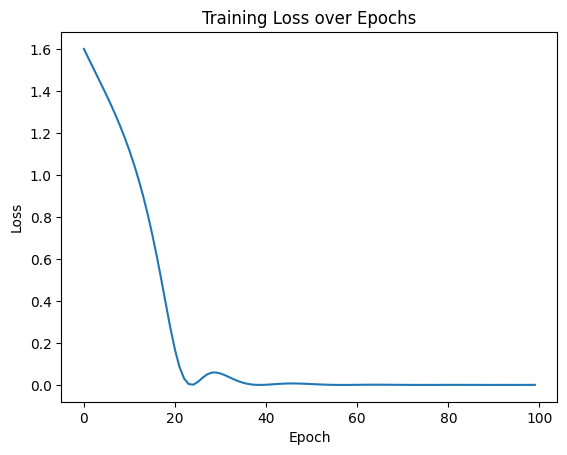

In [11]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [23]:
data_tensor

tensor([[[1.1211],
         [1.1214],
         [1.1212],
         ...,
         [0.0125],
         [0.0125],
         [0.0125]]], device='cuda:0')

In [12]:
# Save the trained model to local device
torch.save(model.state_dict(), './TrainedModals/lstm_model_2024-100ep.pth')

### Evaulate saved modal

In [18]:
from torchsummary import summary  # For model summary

model.load_state_dict(torch.load("./TrainedModals/lstm_model_2024-100ep.pth"))  # Adjust filename as needed

# Inspect model architecture
print("Model architecture:")
print(model)

# Move the model to CPU if it was trained on GPU
model.to('cpu')

# Perform inference
with torch.no_grad():
    output = model(data_tensor.unsqueeze(0))  # Add batch dimension if necessary
    predicted_close = output.item()  # Assuming output size is 1

# Print the predicted close price
print("Predicted close price:", predicted_close)

Model architecture:
LSTM(
  (lstm): LSTM(1, 32, num_layers=5, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead